In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [281]:
db = pd.read_csv('london_merged.csv')

In [282]:
db.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [283]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [284]:
db = db.drop(columns=['timestamp'], axis=1)

In [285]:
db.nunique()

cnt             3781
t1                73
t2                82
hum              143
wind_speed       103
weather_code       7
is_holiday         2
is_weekend         2
season             4
dtype: int64

### Step 1

Distribution of continuous MRV

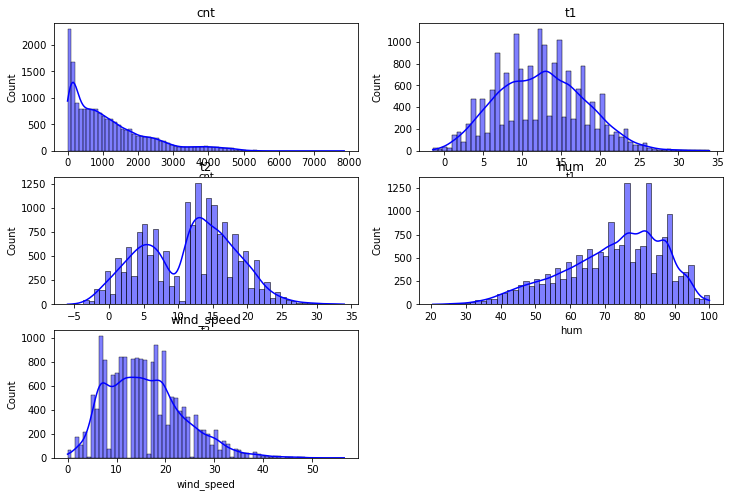

In [286]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(db.loc[:,:'wind_speed'].columns):
    plt.subplot(3, 2, i + 1)
    sns.histplot(db[col],kde=True,color='b')
    plt.title(col);

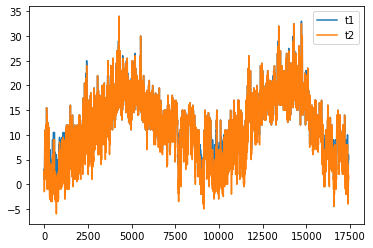

In [287]:
db[["t1", "t2"]].plot();

We can see those two features are highly connected

C:\Users\1vany\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


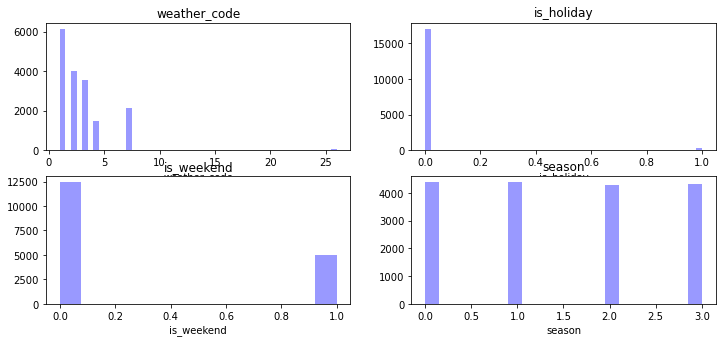

In [288]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(db.loc[:,'weather_code':].columns):
    plt.subplot(3, 2, i + 1)
    sns.distplot(db[col], kde=False, color='blue')
    plt.title(col);

In [289]:
for i in db.loc[:,'weather_code':].columns:
    print(f'Probability law of {i} \n')
    print(pd.Series([x/db.shape[0] for x in db[i].value_counts()]))

Probability law of weather_code 

0    0.353164
1    0.231653
2    0.203916
3    0.122947
4    0.084070
5    0.003446
6    0.000804
dtype: float64
Probability law of is_holiday 

0    0.977949
1    0.022051
dtype: float64
Probability law of is_weekend 

0    0.714597
1    0.285403
dtype: float64
Probability law of season 

0    0.252326
1    0.251924
2    0.248651
3    0.247100
dtype: float64


### Step 2

Mathematical expectation of each column

In [290]:
db.apply(np.mean)

cnt             1143.101642
t1                12.468091
t2                11.520836
hum               72.324954
wind_speed        15.913063
weather_code       2.722752
is_holiday         0.022051
is_weekend         0.285403
season             1.492075
dtype: float64

Variance for each column

In [291]:
db.apply(np.var)

cnt             1.177392e+06
t1              3.104337e+01
t2              4.375763e+01
hum             2.048555e+02
wind_speed      6.232066e+01
weather_code    5.480731e+00
is_holiday      2.156497e-02
is_weekend      2.039479e-01
season          1.251890e+00
dtype: float64

### Step 3

Extract data with count > median value

In [292]:
maj_db = db[db['cnt'] > db['cnt'].median()]

In [293]:
maj_db.loc[:, "t1":].apply(np.mean)

t1              14.479124
t2              13.799567
hum             65.183004
wind_speed      17.175381
weather_code     2.365088
is_holiday       0.014365
is_weekend       0.233624
season           1.390025
dtype: float64

In [294]:
maj_db.loc[:, "t1":].apply(np.var)

t1               31.802151
t2               42.713584
hum             215.101967
wind_speed       57.292063
weather_code      2.708931
is_holiday        0.014158
is_weekend        0.179044
season            1.117703
dtype: float64

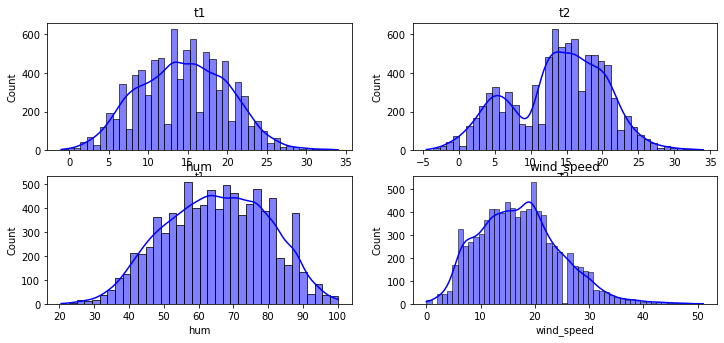

In [295]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(maj_db.loc[:, "t1":'wind_speed'].columns):
    plt.subplot(3, 2, i + 1)
    sns.histplot(maj_db[col],kde=True,color='b')
    plt.title(col);

The most difference we can see in the distribution of humidity

### Step 4

<AxesSubplot:>

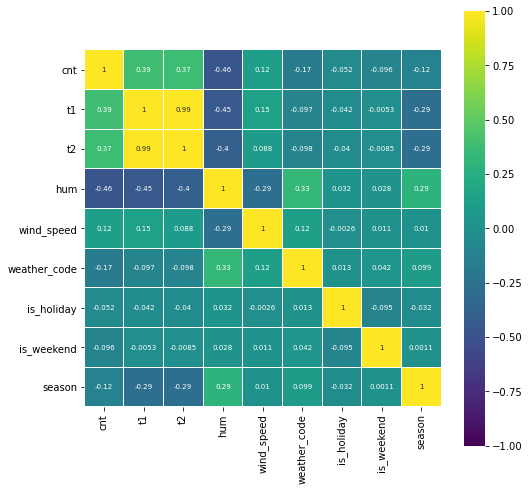

In [296]:
plt.figure(figsize=(8, 8))
corrmat = db.corr()
sns.heatmap(corrmat, cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 7}, square=True)

In [297]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

In [298]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(stats.pearsonr(df[r], df[c])[1], 4)
    return pvalues

Significance levels for correlation matrix

In [299]:
calculate_pvalues(corrmat) 

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
cnt,0.0,0.0356,0.0418,0.0045,0.5143,0.1047,0.6241,0.4938,0.168
t1,0.0356,0.0,0.0,0.006,0.5716,0.1641,0.5959,0.6785,0.0295
t2,0.0418,0.0,0.0,0.0095,0.6546,0.1676,0.6016,0.6779,0.03
hum,0.0045,0.006,0.0095,0.0,0.1548,0.0926,0.8339,0.836,0.0889
wind_speed,0.5143,0.5716,0.6546,0.1548,0.0,0.8873,0.7202,0.7685,0.6002
weather_code,0.1047,0.1641,0.1676,0.0926,0.8873,0.0,0.8697,0.9786,0.5184
is_holiday,0.6241,0.5959,0.6016,0.8339,0.7202,0.8697,0.0,0.4742,0.8418
is_weekend,0.4938,0.6785,0.6779,0.836,0.7685,0.9786,0.4742,0.0,0.9362
season,0.168,0.0295,0.03,0.0889,0.6002,0.5184,0.8418,0.9362,0.0


In [300]:
intervals = mean_confidence_interval(corrmat)

In [301]:
for i in range(db.shape[1]):
    print(f'p-value column {db.columns[i]} confidence interval: ({intervals[0][i]}, {intervals[1][i]})')

p-value column cnt confidence interval: (-0.21603584161358336, 0.44108397147097833)
p-value column t1 confidence interval: (-0.28523860483991215, 0.5102867346973071)
p-value column t2 confidence interval: (-0.28026051368827626, 0.5053086435456713)
p-value column hum confidence interval: (-0.2578990925840438, 0.4829472224414388)
p-value column wind_speed confidence interval: (-0.15643334581792667, 0.38148147567532165)
p-value column weather_code confidence interval: (-0.16089193760373255, 0.3859400674611275)
p-value column is_holiday confidence interval: (-0.15229645377864487, 0.37734458363603984)
p-value column is_weekend confidence interval: (-0.15033474678078712, 0.3753828766381821)
p-value column season confidence interval: (-0.18774919529811013, 0.4127973251555051)


### Step 5

Target feature is a count of bikes, correlation with predictors calculated in previous step

### Step 6

In [302]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [303]:
X_train, X_val, y_train, y_val = train_test_split(db.drop('cnt', axis=1), db['cnt'], random_state=17)

In [304]:
linreg = LinearRegression(normalize=True)

In [305]:
linreg.fit(X_train, y_train)

LinearRegression(normalize=True)

In [306]:
params = linreg.coef_

In [323]:
def coefs(coefs, feature_names=db.drop('cnt', axis=1).columns):
    return pd.DataFrame(coefs, index=feature_names,
                       columns=['coef']).sort_values('coef',
                                                  ascending=False)

In [308]:
coefs(linreg.coef_)

,coef
t1,69.447481
season,60.100982
wind_speed,-4.479778
weather_code,-8.645197
t2,-19.011091
hum,-28.023112
is_weekend,-214.590349
is_holiday,-286.903971


In [309]:
y_pred = linreg.predict(X_val)

In [310]:
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

Mean absolute error =  680.5047330693583
Mean squared error =  846935.2186139161


Lasso regression

In [311]:
clf = Lasso(alpha=0.1, normalize=True)
clf.fit(X_train, y_train)

Lasso(alpha=0.1, normalize=True)

In [312]:
coefs(clf.coef_)

,coef
t1,44.428249
season,43.645366
t2,0.000000
wind_speed,-1.637305
weather_code,-6.255301
hum,-27.404364
is_weekend,-187.511085
is_holiday,-213.567450


In [313]:
mae_lasso = mean_absolute_error(y_val, clf.predict(X_val))
mse_lasso = mean_squared_error(y_val, clf.predict(X_val))
print('Mean absolute error = ', mae_lasso)
print('Mean squared error = ', mse_lasso)

Mean absolute error =  680.2201734107324
Mean squared error =  846665.2577758167


Let's drop column with highest pair correlation

In [314]:
db = db.drop('t2', axis=1)

In [320]:
X_train, X_val, y_train, y_val = train_test_split(db.drop('cnt', axis=1), db['cnt'], random_state=17)

In [321]:
clf = Lasso(alpha=0.1, normalize=True)
clf.fit(X_train, y_train)

Lasso(alpha=0.1, normalize=True)

In [326]:
coefs(clf.coef_, feature_names=db.drop('cnt', axis=1).columns)

,coef
t1,44.428249
season,43.645366
wind_speed,-1.637305
weather_code,-6.255301
hum,-27.404364
is_weekend,-187.511085
is_holiday,-213.567450


In [327]:
mae_lasso = mean_absolute_error(y_val, clf.predict(X_val))
mse_lasso = mean_squared_error(y_val, clf.predict(X_val))
print('Mean absolute error = ', mae_lasso)
print('Mean squared error = ', mse_lasso)

Mean absolute error =  680.2201734107324
Mean squared error =  846665.2577758167


Polynomial model 2nd degree

In [335]:
poly = PolynomialFeatures(2)
X_train_new = poly.fit_transform(X_train)
poly = PolynomialFeatures(2)
X_test_new = poly.fit_transform(X_val)
reg = LinearRegression(normalize=True)
reg.fit(X_train_new, y_train)
y_pred_poly = reg.predict(X_test_new)
X_new = poly.fit_transform(db.drop('cnt', axis=1))
y_pred_poly_all = reg.predict(X_new)

In [333]:
mae_poly = mean_absolute_error(y_val, y_pred_poly)
mse_poly = mean_squared_error(y_val, y_pred_poly)
print('Mean absolute error with Polynomial model = ', mae_poly)
print('Mean squared error with Polynomial model = ', mse_poly)

Mean absolute error with Polynomial model =  659.6107591379913
Mean squared error with Polynomial model =  814928.8032474559


Polynomial model has the best precision between observed models

### Step 7

Text(0, 0.5, 'Prediction')

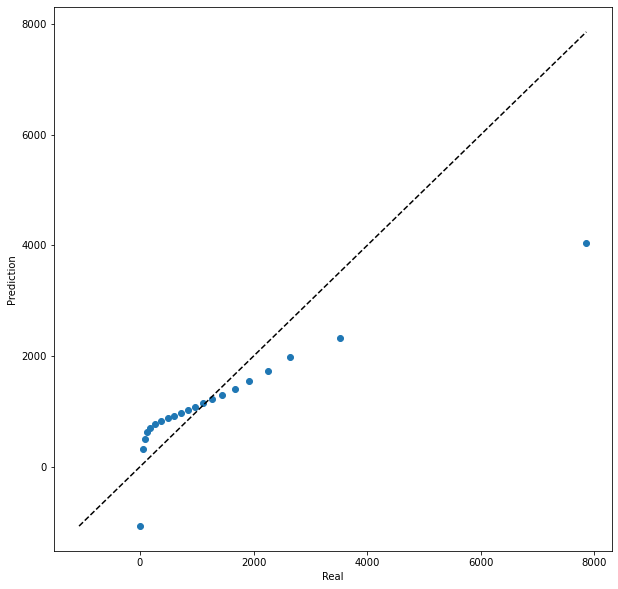

In [336]:
# Plotting a quantile biplot based on real and predicted values
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(db['cnt'], percs)
qn_second = np.percentile(y_pred_poly_all , percs)
plt.figure(figsize=(10, 10))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")

plt.xlabel(u'Real')
plt.ylabel(u'Prediction')

C:\Users\1vany\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

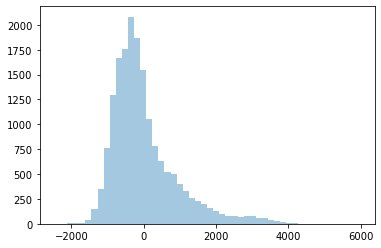

In [344]:
# Plotting the distribution of residuals
y1 = np.array(db['cnt'])
y2 = np.array(y_pred_poly_all)
y_diff = y1[:] - y2[:]
sns.distplot(y_diff, kde=False)

In [347]:
#Confidence interval of regression coef 
import numpy as np, statsmodels.api as sm
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print (res.conf_int(0.01))  


                       0           1
t1             83.674182   90.855401
hum            -3.620546   -1.799967
wind_speed     13.872334   19.280621
weather_code  -52.859328  -32.262757
is_holiday   -376.662701  -72.442520
is_weekend   -227.860720 -129.086545
season         57.451334   99.898716
